# Localization Examples

This notebook demonstrates how to implement and use the base classes from the localization modules. Their strengths, weaknesses, and performance will be examined using one dimensional test case to demonstrate how to use the library and a two-dimensional Cartesian plane example similar to the examples found [here](https://www.kalmanfilter.net/multiExamples.html) to analyze performance. We will use an scenario similar to example 9.

## General State Equation

As a refresher, the general form of the state equation is

\begin{equation}
\textbf{x}_{t} = \textbf{F} \textbf{x}_{t-1} + \textbf{B} \textbf{u}_t + \textbf{w}_t
\end{equation}

Where:
* $\textbf{x}_{t}$ is the system state at the current time step
* $\textbf{x}_{t-1}$ is the system state from the prior time step
* $\textbf{u}_t$ is the current control input
* $\textbf{F}$ is the state transition matrix, sometimes noted as $\textbf{A}$
* $\textbf{B}$ is the control input matrix, sometimes noted as $\textbf{G}$

We will also make use of a measurement equation which relates the current state estimate to a measurement $\textbf{z}_t$.

\begin{equation}
\textbf{z}_t = \textbf{H}_t \textbf{x}_{t} + \textbf{v}_t
\end{equation}

Note, in my notation bold-faced lowercase symbols are vectors, bold-faced uppercase symbols are matricies. Non-bold versions of the same symbol will indicate an element of that matrix or vector quantity. Ex: $x_t^i$ is the *i*-th element of the vector $\textbf{x}_t$. 


## Kalman Filter Basic Theory

The Kalman Filter consists of two equations that describe how the mean ($\textbf{x}_t$) and covariance ($\textbf{P}_t$) of a Guassian distribution based on the above state equation evolve over time with respect to a measurement vector $\textbf{z}_t$. However, it is frequently expanded to seven equations for readability and broken into two distinct phases: the prediction phase and the update phase.

**Prediction**
1. $\hat{\textbf{x}}_t = \textbf{F} \textbf{x}_t + \textbf{B} \textbf{u}_t$
2. $\hat{\textbf{P}}_t = \textbf{F} \textbf{P}_t \textbf{F}^T + \textbf{Q}$

**Update**
1. $\textbf{y} = \textbf{z}_t - \textbf{H} \hat{\textbf{x}}_t$
2. $\textbf{S} = \textbf{H} \hat{\textbf{P}} \textbf{H}^T + \textbf{R}$
3. $\textbf{K} = \hat{\textbf{P}}_t \textbf{H}^T \textbf{S}^-1$
4. $\textbf{x}_{t+1} = \hat{\textbf{x}}_t + \textbf{K} \textbf{y}$
5. $\textbf{P}_{t+1} = \left(\textbf{I} - \textbf{K}\textbf{H}\right) \hat{\textbf{P}}$

The Kalman Filter assumes that the system is linear and is well suited to uni-axial scenarios. 

## One dimensional

This example serves as a unit test for the library as well as a general walkthrough of how to use it. We will start off using a constant acceleration one dimensional mostion model. We will treat the moving object as a point mass with a sensor that measures its distance from the origin. We will examine this both without and with a control input. The state vector is the position, velocity, and acceleration.

\begin{equation}
\textbf{x}_t = \left[p, v, a \right]
\end{equation}

The measurement vector $\textbf{z}_t = [p_z]$ is simply the distance to the origin.

### Without control inputs

In this scenario we use the above dynamic model. Our only input to the system are position measurements Using this dynamic model and measurement model we can create the $\textbf{F}$ and $\textbf{H}$ matricies.

$\textbf{F} = \left[ \begin{matrix}1 & dt & \frac{1}{2}dt^2 \\ 0 & 1  & dt \\ 0 & 0  & 1 \\ \end{matrix} \right]$ 

$\textbf{H} = \left[\begin{matrix} 1 & 0 & 0 \\ \end{matrix} \right]$

This leaves the process noise matrix $\textbf{Q}$ and measurement noise matrix $\textbf{R}$. This process noise matrix can be calculated using two different methods depending on whether or not you have control inputs. Since we do not in this case, we will calculate it using the state transition matrix. This method first requires determining your noise parameters ($\sigma^2$), and how they map to the state state transition matrix ($\bar{\textbf{Q}}$). Typically the noise parameter is placed on the highest order derivative. The noise parameter(s) can be brought in through sensor specifications (ex: if a sensor reports a measurement $z$ accurate to $\pm \sigma$) or just left as scalar of one. Putting the noise on the acceleration only we get:

\begin{equation}
\bar{\textbf{Q}} = \left[\begin{matrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 1\\ \end{matrix}\right]
\end{equation}

\begin{equation}
\textbf{Q} = \textbf{F} \bar{\textbf{Q}} \textbf{F}^{T} = \left[\begin{matrix} \frac{t^4}{4} & \frac{t^3}{2} & \frac{t^2}{2}\\ \frac{t^3}{2} & t^2           & t \\ \frac{t^2}{2} & t             & 1 \end{matrix}\right]
\end{equation}

The advantage of the Kalman Filter is its ability to create accurate estimates from inaccurate and infrequent measurements. This is modeled in the $\textbf{R}$ matrix. Let's start with a demonstration.

First we need to generate a base truth. Again, we'll start by showing a one-dimensional constant acceleration case.

In [157]:
import numpy as np
from gaussian import KalmanFilter

start = 0.0
stop = 60*60.0
dt = 1.0
x = 0.0
v = 0.0
a = 1000.0 / (1600.0**2)
times = np.arange(start, stop, dt)
pos = []
upper_old = []
lower_old = []
upper_new = []
lower_new = []
upper_laser = []
lower_laser = []

In [158]:
for t in times:
    # Append the base position
    pos.append(x)
    # Calculate the propagated error to determine the error envelope
    upper_old.append(x+15.0*t)
    lower_old.append(x-15.0*t)
    upper_new.append(x+5.0*t)
    lower_new.append(x-5.0*t)
    upper_laser.append(x+0.1*t)
    lower_laser.append(x-0.1*t)
    # Calculate the next position
    x += v * dt + 0.5 * a * dt**2
    v += a * dt

Let's plot the position over time

[Text(0, 0.5, 'Position (m)'), Text(0.5, 1.0, 'Truth Position')]

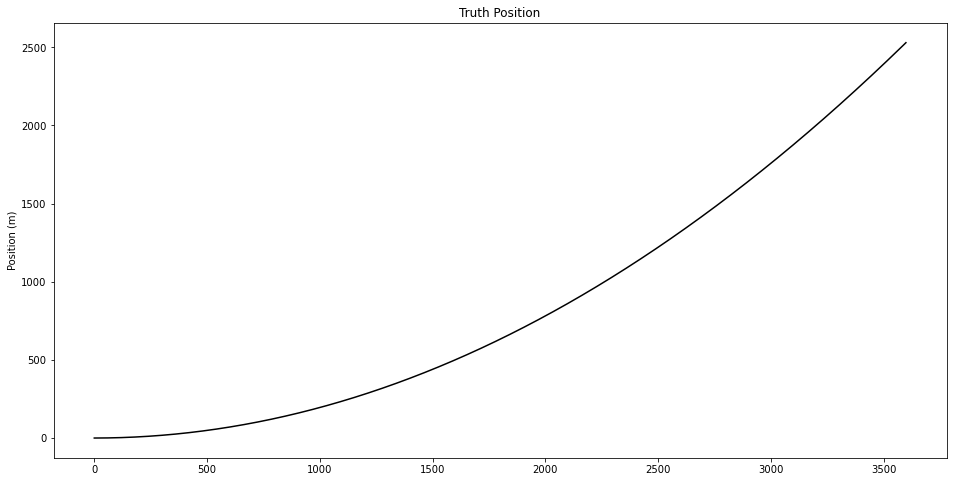

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(16, 8))
ax.plot(times, pos, '-k')
ax.set(ylabel='Position (m)', title='Truth Position')

Let's assume we use a very coarse position sensor such as GPS. While modern GPS systems such as what you can find in a typical smart phone are typically able to achieve a 5m accuracy, older systems could only achieve approximately 15m. We'll examine both, as well as a very accurate system such as a laser range finder. First lets see how these errors would propagate over time if uncorrected.

Laser error at end of trajectory: 719.8000000000002 meters


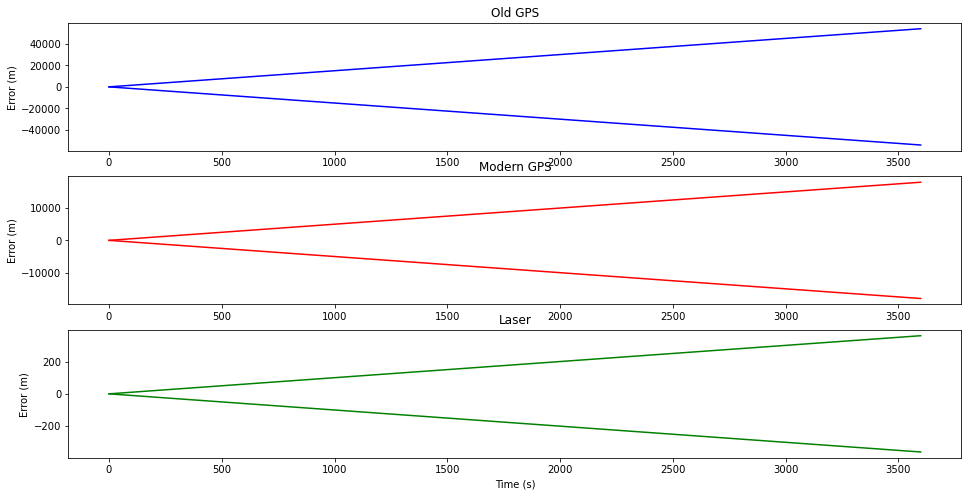

In [160]:
fig, ax = plt.subplots(3,1, figsize=(16, 8))
ax[0].plot(times, np.array(upper_old) - np.array(pos), '-b', 
            times, np.array(lower_old) - np.array(pos), '-b')
ax[1].plot(times, np.array(upper_new) - np.array(pos), '-r', 
            times, np.array(lower_new) - np.array(pos), '-r')
ax[2].plot(times, np.array(upper_laser) - np.array(pos), '-g', 
        times, np.array(lower_laser) - np.array(pos), '-g')
ax[0].set(ylabel='Error (m)', title='Old GPS')
ax[1].set(ylabel='Error (m)', title='Modern GPS')
ax[2].set(xlabel='Time (s)', ylabel='Error (m)', title='Laser')

errs = (np.array(upper_laser) - np.array(pos))
print(f'Laser error at end of trajectory: {errs[-1]*2} meters')

As you can see, depending on the sensor we can have a very inaccurate position estimate if we just chain a series of measurements together. Even with the very accurate laser range finder we can still have nearly a kilometer of error. This is where the Kalman Filter comes in handy. Let's see how.

In [161]:
# Generate measurments
z_gps_modern = []
z_gps_old = []
z_laser = []

for x in pos:
    z_gps_modern.append(np.random.normal(x, 5.0))
    z_gps_old.append(np.random.normal(x, 15.0))
    z_laser.append(np.random.normal(x, 0.1))

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Position (m)'),
 Text(0.5, 1.0, 'Laser')]

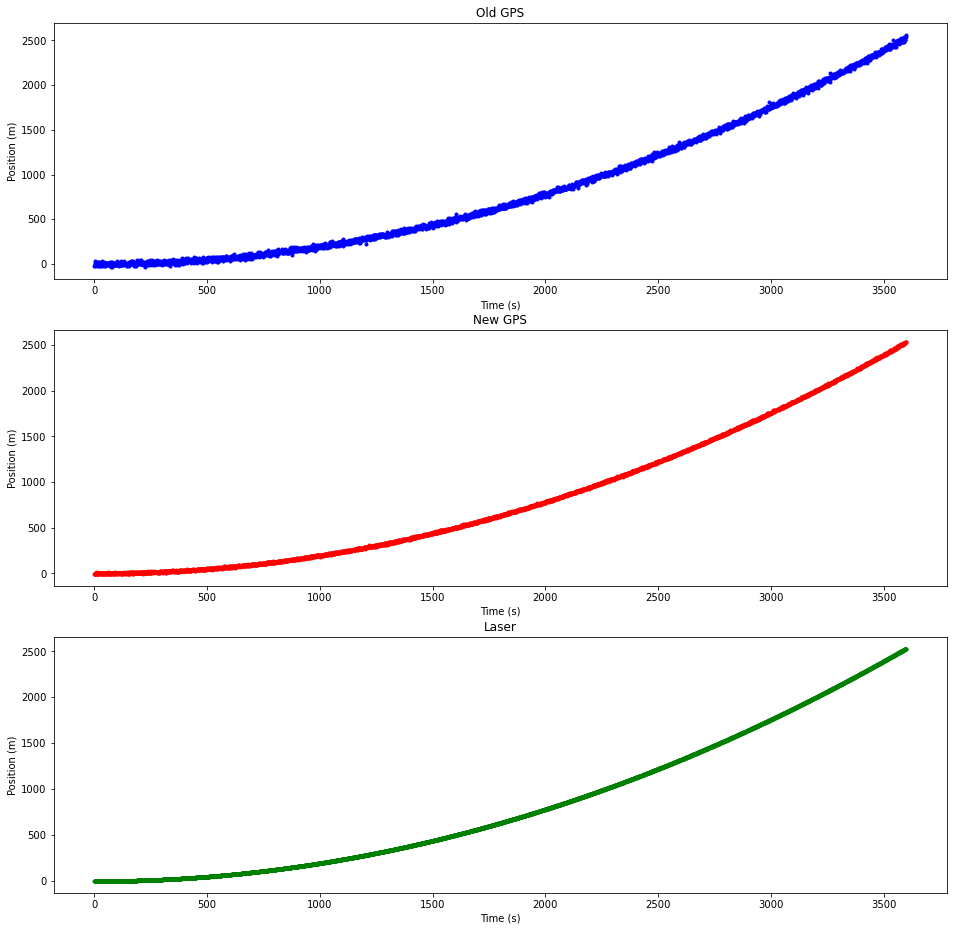

In [162]:
# Plot the measurements
fig, ax = plt.subplots(3,1, figsize=(16,16))
ax[0].plot(times, z_gps_old, '.b')
ax[0].set(xlabel='Time (s)', ylabel='Position (m)', title='Old GPS')
ax[1].plot(times, z_gps_modern, '.r')
ax[1].set(xlabel='Time (s)', ylabel='Position (m)', title='New GPS')
ax[2].plot(times, z_laser, '.g')
ax[2].set(xlabel='Time (s)', ylabel='Position (m)', title='Laser')

Now lets construct the Kalman Filters and run them through the trajectories.

In [173]:
from gaussian import KalmanFilter

kf_old = KalmanFilter(x_dim=3, u_dim=0, z_dim=1)

F = np.array([[1, dt, 0.5*dt*dt], [0, 1, dt], [0, 0, 1]])
Qbar = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]])
H = np.array([[1,0,0]])
kf_old.set_state_transition_matrix(F)
kf_old.set_measurement_matrix(H)
kf_old.set_measurement_noise_matrix([15**2])
kf_old.set_process_noise_matrix(Qbar)
kf_old.initialize([0,0,0], np.eye(3)*100)

kf_modern = KalmanFilter(x_dim=3, u_dim=0, z_dim=1)
kf_modern.set_state_transition_matrix(F)
kf_modern.set_measurement_matrix(H)
kf_modern.set_measurement_noise_matrix([5**2])
kf_modern.set_process_noise_matrix(Qbar)
kf_modern.initialize([0,0,0], np.eye(3)*100)

kf_laser = KalmanFilter(x_dim=3, u_dim=0, z_dim=1)
kf_laser.set_state_transition_matrix(F)
kf_laser.set_measurement_matrix(H)
kf_laser.set_measurement_noise_matrix([0.1**2])
kf_laser.set_process_noise_matrix(Qbar)
kf_laser.initialize([0,0,0], np.eye(3)*100)

Kalman Filter constructed. Please manaully initialize matrix values.
Kalman Filter constructed. Please manaully initialize matrix values.
Kalman Filter constructed. Please manaully initialize matrix values.


In [164]:
# Run the measurements through the Kalman Filters
est_old = []
est_modern = []
est_laser = []
for i, t in enumerate(times):
    kf_old.step(z=[z_gps_old[i]])
    est_old.append(kf_old.x[0])
    kf_modern.step(z=[z_gps_modern[i]])
    est_modern.append(kf_modern.x[0])
    kf_laser.step(z=[z_laser[i]])
    est_laser.append(kf_laser.x[0])

Text(0.5, 0.98, 'Kalman Filter Estimate Errors (m)')

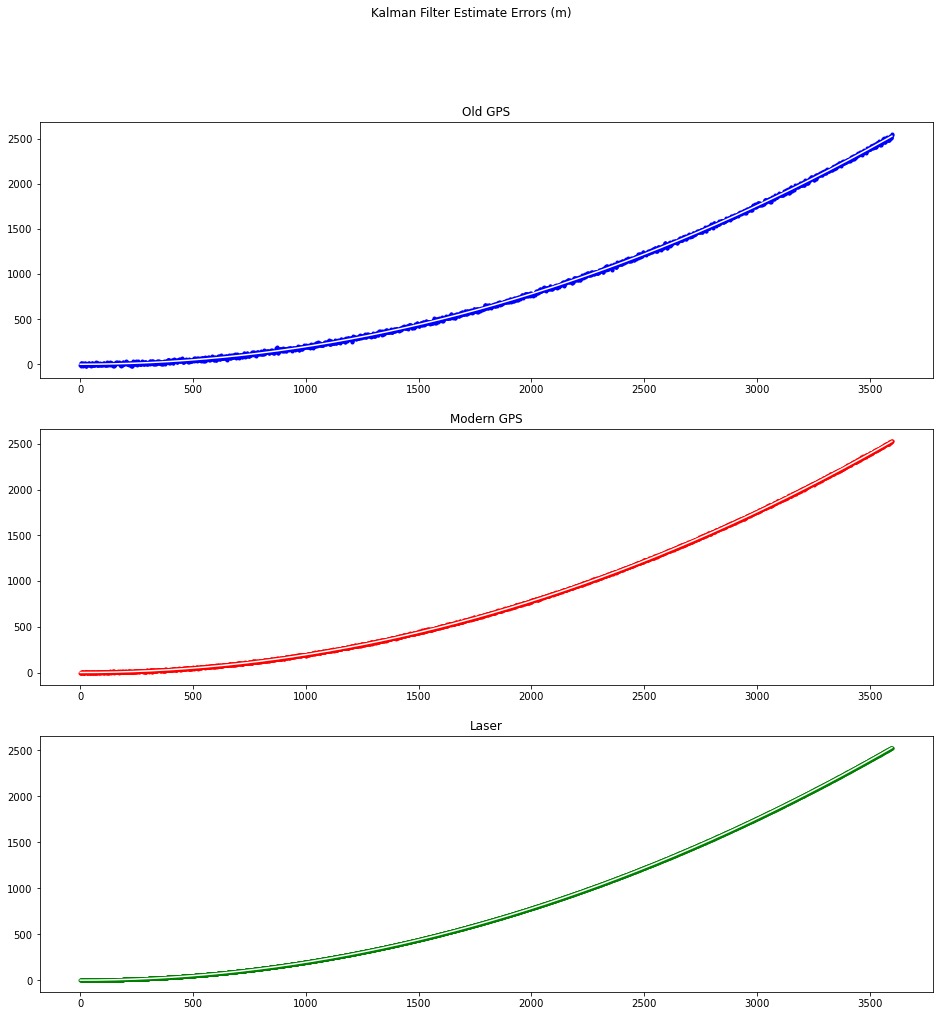

In [165]:
# Plot the results
err_old = np.array(pos) - np.array(est_old)
err_modern = np.array(pos) - np.array(est_modern)
err_laser = np.array(pos) - np.array(est_laser)

fig, ax = plt.subplots(3,1, figsize=(16,16))
ax[0].plot(times, est_old, '.b', times, pos, '-w')
ax[0].set(title='Old GPS')
ax[1].plot(times, est_modern, '.r', times, pos, '-w')
ax[1].set(title='Modern GPS')
ax[2].plot(times, est_laser, '.g', times, pos, '-w')
ax[2].set(title='Laser')
plt.suptitle('Kalman Filter Estimate Errors (m)')


As you can see from the results, the Kalman Filter is a pretty versatile and powerful tool. However from this we can also see that it is both heavily dependent on the measurement accuracy, and we seem to be overwhelming the estimation ability of the Kalman Filter with the shear number of measurements. Let's look at how they perform with less frequent measurements (measurements now every 10 seconds).

In [166]:
# Generate the new measurements with a 10 second period
z_times = []
z_gps_old = []
z_gps_modern = []
z_laser = []
for i, t in enumerate(times):
    if t % 10.0 == 0.0:
        z_times.append(t)
        x = pos[i]
        z_gps_modern.append(np.random.normal(x, 5.0))
        z_gps_old.append(np.random.normal(x, 15.0))
        z_laser.append(np.random.normal(x, 0.1))

In [167]:
# Re-initialize the Kalman Filters
kf_old.initialize([0,0,0], np.eye(3)*100)
kf_modern.initialize([0,0,0], np.eye(3)*100)
kf_laser.initialize([0,0,0], np.eye(3)*100)

# Run the measurements through the Kalman Filters
est_old = []
est_modern = []
est_laser = []

I = 0 # Observation index

for i, t in enumerate(times):
    #
    if I < len(z_times) and t == z_times[I]:
        z_old = [z_gps_old[I]]
        z_modern = [z_gps_modern[I]]
        z_lsr = [z_laser[I]]
        I += 1
    else:
        z_old = None
        z_modern = None
        z_lsr = None
    kf_old.step(z=z_old)
    est_old.append(kf_old.x[0])
    kf_modern.step(z=z_modern)
    est_modern.append(kf_modern.x[0])
    kf_laser.step(z=z_lsr)
    est_laser.append(kf_laser.x[0])
# Calculate the errors
err_old = np.array(pos) - np.array(est_old)
err_modern = np.array(pos) - np.array(est_modern)
err_laser = np.array(pos) - np.array(est_laser)

Text(0.5, 0.98, 'Kalman Filter Estimates (m)')

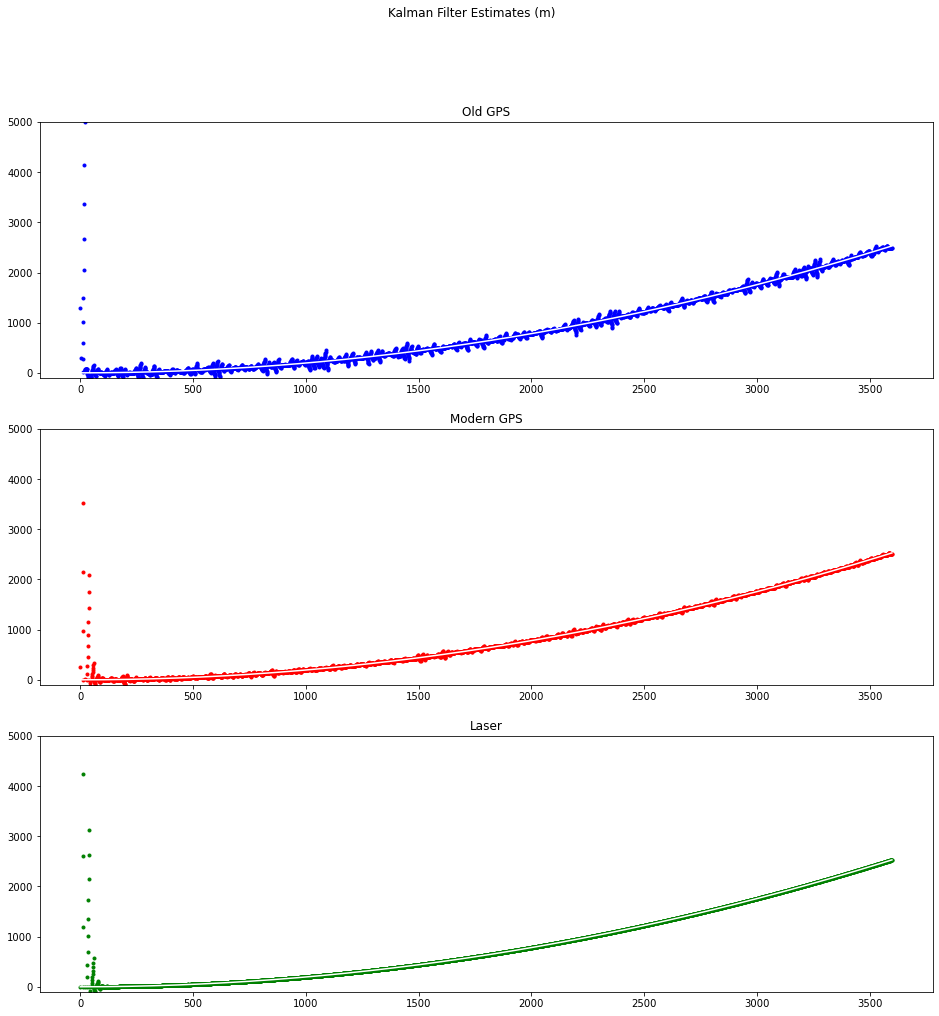

In [171]:
# Plot the results
fig, ax = plt.subplots(3,1, figsize=(16,16))
ax[0].plot(times, est_old, '.b', times, pos, '-w')
ax[0].set(title='Old GPS', ylim=[-100, 5000])
ax[1].plot(times, est_modern, '.r', times, pos, '-w')
ax[1].set(title='Modern GPS', ylim=[-100,5000])
ax[2].plot(times, est_laser, '.g', times, pos, '-w')
ax[2].set(title='Laser', ylim=[-100, 5000])
plt.suptitle('Kalman Filter Estimates (m)')

Text(0.5, 0.98, 'Kalman Filter Estimate Errors (m)')

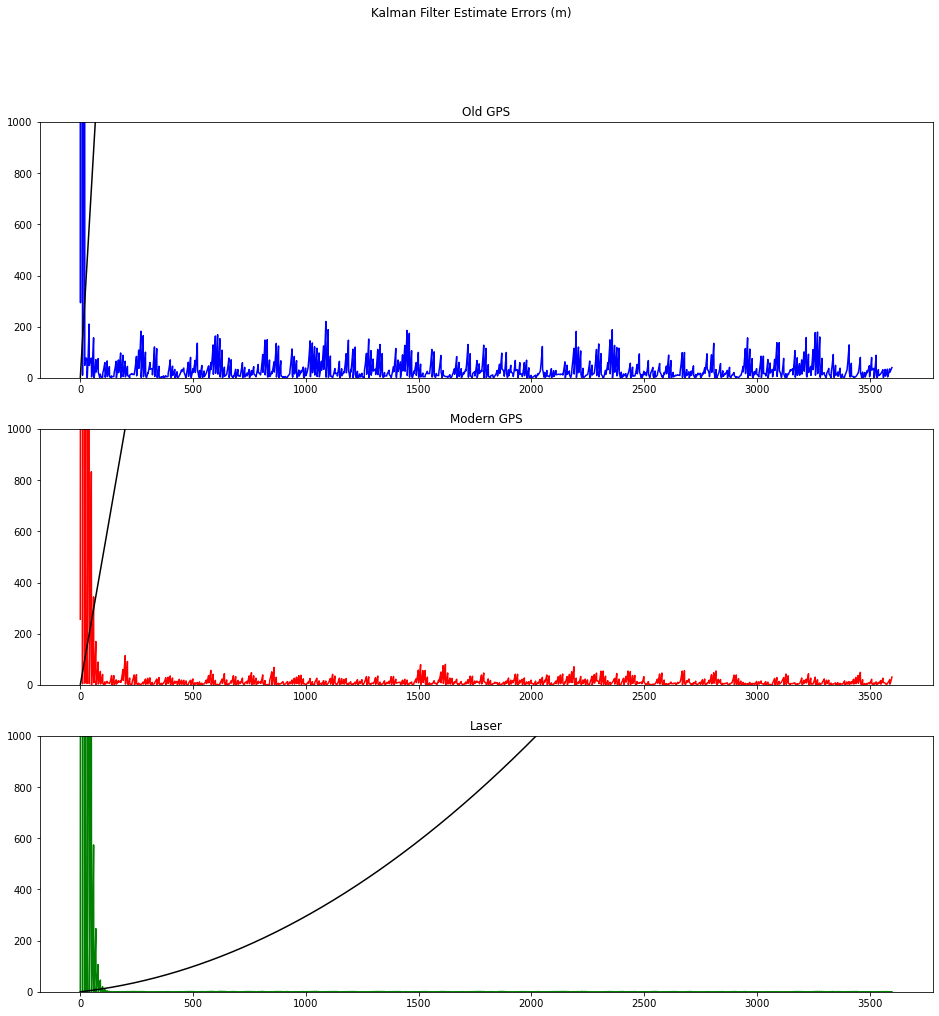

In [172]:
# Plot the errors
fig, ax = plt.subplots(3,1, figsize=(16,16))
ax[0].plot(times, np.sqrt(err_old**2), '-b', times, upper_old, '-k')
ax[0].set(title='Old GPS', ylim=[0, 1000])
ax[1].plot(times, np.sqrt(err_modern**2), '-r', times, upper_new, '-k')
ax[1].set(title='Modern GPS', ylim=[0, 1000])
ax[2].plot(times, np.sqrt(err_laser**2), '-g', times, upper_laser, '-k')
ax[2].set(title='Laser', ylim=[0,1000])
plt.suptitle('Kalman Filter Estimate Errors (m)')

Note how there is an initial high value of error that is quickly brought down and is significantly less than the error envelope.

### With control inputs

Now lets look at the same one-dimensional scenario but with an inertial measurement unit that is able to provide us with an acceleration. Our state vector now just becomes position and velocity: $\textbf{x} = \left[p, v\right]$, with control input $\textbf{u} = \left[a\right]$. This changes the state transition matrix to:

$\textbf{F} = \left[ \begin{matrix}1 & dt \\ 0 & 1 \\ \end{matrix} \right]$ 

The $\textbf{B}$ matrix becomes:

$\textbf{B} = \left[\begin{matrix}0.5t^2 \\ t \\ \end{matrix}\right]$

We can use this to calculate the $\textbf{Q}$ matrix as such: $\textbf{Q} = \textbf{B} \sigma^2 \textbf{B}^T$, where $\sigma$ is the random variance in acceleration.

Again, we are only measuring position so the measurement matrix doesn't change much.

$\textbf{H} = \left[\begin{matrix} 1 & 0 \\ \end{matrix} \right]$

We'll again build the same three Kalman Filters, and run them with the 10 second measurement intervals

In [180]:
F = np.array([[1, dt], [0, 1]])
H = np.array([[1,0]])

kf_old = KalmanFilter(x_dim=2, u_dim=1, z_dim=1)
kf_old.set_state_transition_matrix(F)
kf_old.set_measurement_matrix(H)
kf_old.set_measurement_noise_matrix([15**2])
kf_old.set_control_input_matrix([[0.5*dt**2], [dt]])
kf_old.set_process_noise_matrix([1])
kf_old.initialize([0,0], np.eye(2)*100)

kf_modern = KalmanFilter(x_dim=2, u_dim=1, z_dim=1)
kf_modern.set_state_transition_matrix(F)
kf_modern.set_measurement_matrix(H)
kf_modern.set_measurement_noise_matrix([15**2])
kf_modern.set_control_input_matrix([[0.5*dt**2], [dt]])
kf_modern.set_process_noise_matrix([1])
kf_modern.initialize([0,0], np.eye(2)*100)

kf_laser = KalmanFilter(x_dim=2, u_dim=1, z_dim=1)
kf_laser.set_state_transition_matrix(F)
kf_laser.set_measurement_matrix(H)
kf_laser.set_measurement_noise_matrix([15**2])
kf_laser.set_control_input_matrix([[0.5*dt**2], [dt]])
kf_laser.set_process_noise_matrix([1])
kf_laser.initialize([0,0], np.eye(2)*100)

Kalman Filter constructed. Please manaully initialize matrix values.
Kalman Filter constructed. Please manaully initialize matrix values.
Kalman Filter constructed. Please manaully initialize matrix values.


In [182]:
# Run the measurements through the Kalman Filters
est_old = []
est_modern = []
est_laser = []

I = 0 # Observation index

for i, t in enumerate(times):
    #
    if I < len(z_times) and t == z_times[I]:
        z_old = [z_gps_old[I]]
        z_modern = [z_gps_modern[I]]
        z_lsr = [z_laser[I]]
        I += 1
    else:
        z_old = None
        z_modern = None
        z_lsr = None
    kf_old.step(u=[a], z=z_old)
    est_old.append(kf_old.x[0])
    kf_modern.step(u=[a], z=z_modern)
    est_modern.append(kf_modern.x[0])
    kf_laser.step(u=[a], z=z_lsr)
    est_laser.append(kf_laser.x[0])
# Calculate the errors
err_old = np.array(pos) - np.array(est_old)
err_modern = np.array(pos) - np.array(est_modern)
err_laser = np.array(pos) - np.array(est_laser)

Text(0.5, 0.98, 'Kalman Filter Estimate Errors (m)')

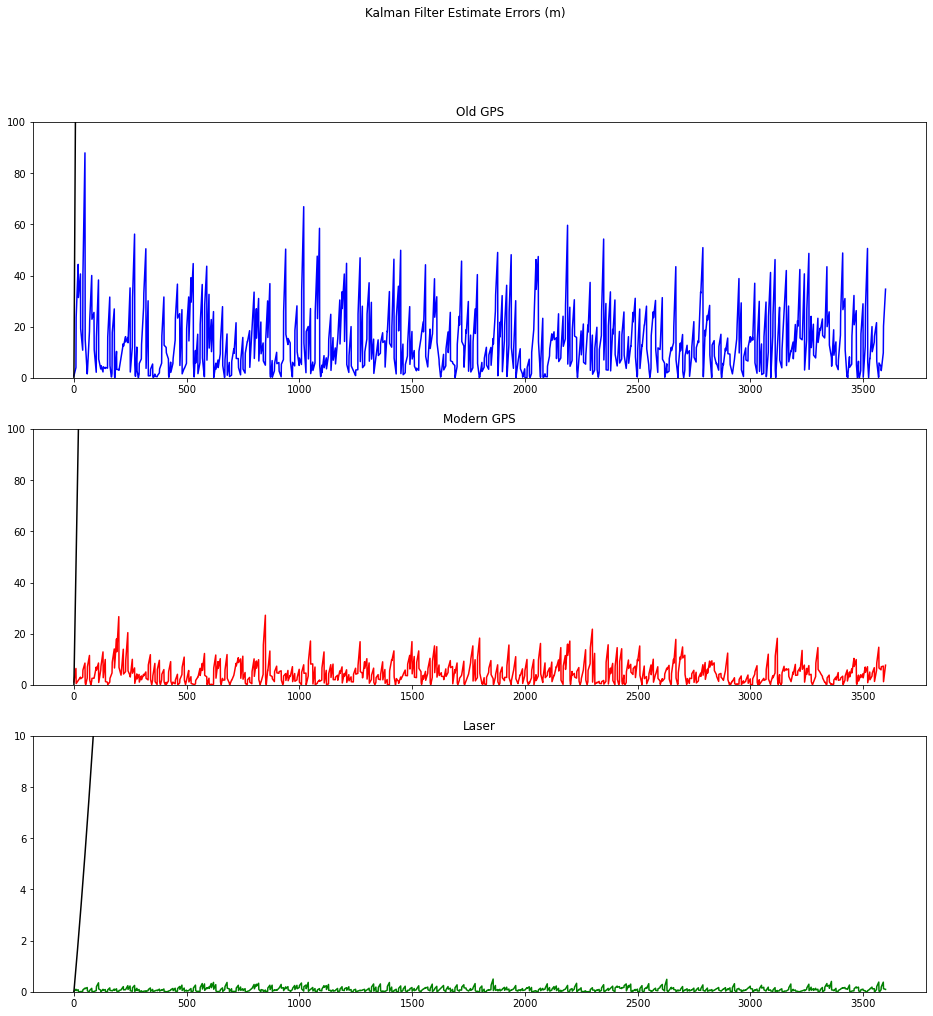

In [185]:
# Plot the errors
fig, ax = plt.subplots(3,1, figsize=(16,16))
ax[0].plot(times, np.sqrt(err_old**2), '-b', times, upper_old, '-k')
ax[0].set(title='Old GPS', ylim=[0, 100])
ax[1].plot(times, np.sqrt(err_modern**2), '-r', times, upper_new, '-k')
ax[1].set(title='Modern GPS', ylim=[0, 100])
ax[2].plot(times, np.sqrt(err_laser**2), '-g', times, upper_laser, '-k')
ax[2].set(title='Laser', ylim=[0,10])
plt.suptitle('Kalman Filter Estimate Errors (m)')

There is an even greater increase in performance using control inputs!

## Two dimensional

In this scenario our state vector becomes the position along the world x- and y-axes, and the angular position, velocity, and acceleration of the body frame x-axis relative to the world x-axis, and the body frame velocities ($v_x$, and $v_y$) and accelerations ($a_x$, and $a_y$). Assume a vehicle is traveling in an plane and that the vehicle can be modeled as a point mass with three degrees of freedom (two translational and one rotational). The vehicle has a sensor on board that reports the range and bearing of a landmark located at the origin as well as an inertial measurment unit that can measure accelerations in the body frame (along, athwart, and rotational).



\begin{equation}
\textbf{x}_t = [p_x, p_y, v_x, v_y, a_x, a_y, \theta, \omega, \alpha ]
\end{equation}

**General Dynamic Model**

From basic planar dynamics we can write the following equations assuming a constant acceleration model, where $t$ is the time duration from one step to another:

* $p_x' = p_x + \left(v_x \cos\theta + v_y \cos(\frac{\pi}{2} - \theta)\right) t + 0.5 \left(a_x \cos\theta + a_y \cos(\frac{\pi}{2} - \theta) \right) t^2$
* $p_y' = p_y + \left(v_x \sin\theta + v_y \sin(\frac{\pi}{2} - \theta)\right) t + 0.5 \left(a_x \sin\theta + a_y \cos(\frac{\pi}{2} - \theta) \right) t^2$
* $v_x' = v_x + a_x t$
* $v_y' = v_y + a_y t$
* $\theta ' = \theta + \omega t + 0.5 \alpha t^2$
* $\omega ' = \omega + \alpha t$

As you can see, for a relatively simple case of three degrees of freedom planar motion, this is already getting to be a complicated non-linear model. We'll make one simplifying assumption that there is no side-slippage in the system ($v_y = 0$, and $a_y = 0$) and that the linear velocity and acceleration is only along the body frame x-axis. While this reduces some complexity, it still leaves us with two non-linear terms in the position equations:

* $p_x' = p_x + \left(v t  + 0.5 a t^2\right) \cos\theta$
* $p_y' = p_y + \left(v t + 0.5 a t^2\right) \sin\theta$
* $v' = v + a t$
* $\theta ' = \theta + \omega t + 0.5 \alpha t^2$
* $\omega ' = \omega + \alpha t$



 Therfore, to implement a Kalman Filter for this scenario, we will have to make some changes due to the non-linearities in the position equations and how the measurement is provided. The measurement is pretty simple: instead of directly providing the range and bearing ($\textbf{z} = \left[r, \phi\right]$) to the origin, preprocess the measurement using the IMU's heading angle to calculate the position. 

\begin{equation}
\bar{\textbf{z}}(\theta) = \left[r \cos\left(\theta + \phi\right), r \sin\left(\theta + \phi\right) \right]
\end{equation}

Instead of passing the body-frame accelerations directly into the state equation, we will assume that there is some pre-processing done with the inertial measurement unit that converts the accelerations into the world coordinate frame. We can now use the Kalman Filter two different ways to estimate the state of the vehicle: first by not using the IMU and assuming a constant-acceleration model that includes acceleration in the state vector; second: using the same model but treating the accelerations as control inputs that are measured using the IMU.

### Without control inputs

In this framework our state vector becomes $x_t = \left[p_x, \dot{p}_x, \ddot{p}_x, p_y, \dot{p}_y, \ddot{p}_y \right]$. Our state transition matrix $\textbf{F}$ is therefore just a matrix representation of the one dimensional kinematics equations:

$\textbf{F} = \left[ \begin{matrix}
                1 & t & 0.5 t^2 & 0 & 0 & 0 \\
                0 & 1 & t       & 0 & 0 & 0 \\
                0 & 0 & 1       & 0 & 0 & 0 \\
                0 & 0 & 0 & 1 & t & 0.5 t^2 \\
                0 & 0 & 0 & 0 & 1 & t       \\
                0 & 0 & 0 & 0 & 0 & 1       
              \end{matrix}\right]$

The control input matrix $\textbf{B}$ and vector $\textbf{u}_t$ are simply zero. The measurement matrix $\textbf{H}$ is similarly simple:

$\textbf{H} = \left[
    \begin{matrix}
    1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 1 & 0 & 0 \\
    \end{matrix}
\right]$

The only remaining unknowns are the process noise matrix $\textbf{Q}$ and the measurement uncertainty matrix ($\textbf{R}$). The measurement uncertainty matrix is relatively simple to construct as it is simply a covariance formulation of the measurement accuracy which can be treated as a standard deviation. For example a distance measurement that is accurate to $\pm\sigma$ would result in an $\textbf{R} = \sigma^2$. Typically, these values should only be along the diagonal unless there is some sort of cross-correlation relationship.

This process noise matrix can be calculated using two different methods depending on whether or not you have control inputs. Since we do not in this case, we will calculate it using the state transition matrix. This method first requires determining your noise parameters ($\sigma^2$), and how they map to the state state transition matrix ($\bar{\textbf{Q}}$). Typically the noise parameter is placed on the highest order derivative. The noise parameter(s) can be brought in through sensor specifications (ex: if a sensor reports a measurement $z$ accurate to $\pm \sigma$) or just left as scalar of one. Putting the noise on the acceleration only we get:

\begin{equation}
\bar{\textbf{Q}} = \left[\begin{matrix} 0 & 0 & 0 & 0 & 0 & 0 \\ 
                                        0 & 0 & 0 & 0 & 0 & 0\\ 
                                        0 & 0 & 1 & 0 & 0 & 0\\
                                        0 & 0 & 0 & 0 & 0 & 0\\
                                        0 & 0 & 0 & 0 & 0 & 0\\
                                        0 & 0 & 0 & 0 & 0 & 1
                                        \end{matrix}\right] \sigma^2
\end{equation}

We can then calculate the process noise using the state transition matrix as such: $\textbf{Q} = \textbf{F} \bar{\textbf{Q}} \textbf{F}^T$. In this scenario this results in the following matrix:

\begin{equation}
\textbf{Q} = \left[
             \begin{matrix} 
                \frac{t^4}{4} & \frac{t^3}{2} & \frac{t^2}{2} & 0             & 0             & 0 \\
                \frac{t^3}{2} & t^2           & t             & 0             & 0             & 0 \\
                \frac{t^2}{2} & t             & 1             & 0             & 0             & 0 \\
                0             & 0             & 0             & \frac{t^4}{4} & \frac{t^3}{2} & \frac{t^2}{2} \\
                0             & 0             & 0             & \frac{t^3}{2} & t^2           & t             \\   
                0             & 0             & 0             & \frac{t^2}{2} & t             & 1 \\
             \end{matrix}
            \right] \sigma^2
\end{equation}

### With control inputs

We can thus model our system with the following state vector $ x_t = \left[p_x, \dot{p}_x, p_y, \dot{p}_y, \right]$ and treat the measured accelerations as control inputs: $u_t = \left[\ddot{p}_x, \ddot{p}_y \right]$.

In turn, our state transition matrix $\textbf{F}$ becomes:

$ \textbf{F} = \left[ 
    \begin{matrix}
        1 & t & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & t \\
        0 & 0 & 0 & 1 \\
    \end{matrix}
 \right]$

and the control input matrix $\textbf{B}$ becomes:
$\textbf{B} = \left[ 
    \begin{matrix}
    0.5t^2 & 0 \\
    t      & 0 \\
    0      & 0.5t^2 \\
    0      & t
    \end{matrix}
\right]$

We can similarly calculate the process noise matrix, however this time we use the control input matrix: $\textbf{Q} = \textbf{B} \sigma^2 \textbf{B}^T$. The measurement uncertainty matrix remains the same and $\textbf{H}$ matrix remain the same.

## Testing the Kalman Filter

Now on to testing the Kalman Filter. We will have a truth trajectory that resembles something like a J-shape at a 45 degree angle from the x-axis.

In [ ]:
# set constants and initial conditions
v = 0.1 #m/s
q = np.pi/4
w = 0
x = 0
y = 0
vx = np.cos(q)*v
vy = np.sin(q)*v
truth = {'time': [], 'x': [], 'y':[], 'q':[], 'v': [], 'vx':[], 'vy':[], 'w':[]}
measurements = {'r':[], 'phi':[]}
t = 0
dt = 0.1
# straight line trajectory
while t < 30*60:
    truth['time'].append(t)
    truth['x'].append(x)
    truth['y'].append(y)
    truth['q'].append(q)
    truth['v'].append(v)
    truth['vx'].append(vx)
    truth['vy'].append(vy)
    measurements['r'].append(np.sqrt(x*x + y*y))
    measurements['phi'].append(-np.arctan2(-x, -y) - q)
    x += v*dt*np.cos(q)
    y += v*dt*np.sin(q)
    q += w*dt
    vx = np.cos(q)*v
    vy = np.cos(q)*v
    t+=dt

# half circle trajectory
w = (np.pi/2)/(30*60) # pi radians per 30 minutes
while t < 60*60:
    truth['time'].append(t)
    truth['x'].append(x)
    truth['y'].append(y)
    truth['q'].append(q)
    truth['v'].append(v)
    truth['vx'].append(vx)
    truth['vy'].append(vy)
    measurements['r'].append(np.sqrt(x*x + y*y))
    measurements['phi'].append(-np.arctan2(-x, -y) - q)
    x += v*dt*np.cos(q)
    y += v*dt*np.sin(q)
    q += w*dt
    vx = np.cos(q)*v
    vy = np.cos(q)*v
    t+=dt

In [ ]:
# Plot trajectories
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
ax1.plot(truth['x'], truth['y'])
ax1.set(xlabel='X (m)', ylabel='Y (m)')
ax1.set_title('Truth Position')

ax2.plot(truth['time'], np.degrees(measurements['phi']), '-r', truth['time'], np.degrees(truth['q']))
ax2.set(xlabel='Time (x)', ylabel='deg')
ax2.set_title('Truth angles')

ax3.plot(truth['time'], truth['vx'], '-r', truth['time'], truth['vy'], '--b')
ax3.set(xlabel='Time (s)', ylabel='m/s')
ax3.set_title('Truth velocities')

With the raw trajectory and perfect measurements generated we now need to feed this into the Kalman Filter. To start we will need to add noise to our measurements. A cheap lidar can typicaly report a return that is accurate to $\pm$1 degree and $\pm$5 cm in resolution. Similarly, a cheap simple IMU can report accelerations to $\pm$2g ($\sigma = 19.62 m/s^2$)

This allows us to determine our $\textbf{Q}$ matricies for each scenario.

In [ ]:
# Without control inputs
kf = KalmanFilter(x_dim=6, u_dim=0, z_dim=2)

In [ ]:
f = np.array([[1, dt, dt**2],[0, 1, dt],[0, 0, 1]])
F = np.concatenate((np.concatenate((f, np.zeros((3,3))), axis=1),
                    np.concatenate((np.zeros((3,3)), f), axis=1)), axis=0)
kf.set_state_transition_matrix(F)
R = np.array([[0.05, np.radians(1)]])
kf.set_measurement_noise_matrix(R)
Qbar = np.array([[0,0,0], [0,0,0], [0, 0, 0.1**2]])
Qbar = np.concatenate((np.concatenate((Qbar, np.zeros((3,3))), axis=1),
                       np.concatenate((np.zeros((3,3)), Qbar), axis=1)), axis=0)
kf.set_process_noise_matrix(Qbar)
kf.set_measurement_matrix(np.array([[1,0,0,0,0,0], [0,0,0,1,0,0]]))


In [ ]:
def run_kalman_filter(kf, truth, measurements, end_time, dt, uses_inputs=False):
    t = 0
    i = 0
    mu = np.array([truth['x'][i], truth['vx'][i], 0, truth['y'][i], truth['vy'][i], 0])
    sigma = np.eye(6) * 10
    results = {'estimate':[mu] , 'covariance':[sigma], 'error':[mu-mu]}
    kf.initialize(mu, sigma)
    t += dt
    i += 1
    while t<end_time:
        u = None
        if uses_inputs:
            u = np.array([truth['vx'][i], truth['vy'][i]])
        r = measurements['r'][i]
        phi = measurements['phi'][i]
        obs = np.array([r*np.cos(phi), r*np.sin(phi)])
        kf.step(u, obs)
        mu = np.array([truth['x'][i], truth['vx'][i], 0, truth['y'][i], truth['vy'][i], 0])    
        results['estimate'].append(kf.x)
        results['covariance'].append(kf.P)
        results['error'].append(mu - kf.x)
        t += dt
        i += 1
    return results

def plot_kf_results(truth, results, start, stop, dt):
    fig, axes = plt.subplots(1,6)
    times = np.arange(start, stop+dt, dt)
    for i in range(6):
        err = [item[i] for item in results['error']]
        axes[i].plot(times, err)
    return fig
    

In [ ]:
results = run_kalman_filter(kf, truth, measurements, 60*60, dt)

In [ ]:
fig = plot_kf_results(truth, results, 0, 60*60, dt)
fig.set_figwidth(16)

In [ ]:
x_err = [item[0] for item in results['estimate']]
y_err = [item[3] for item in results['estimate']]

In [ ]:
plt.plot(truth['x'], truth['y'], '-b', x_err, y_err, '-r')

In [ ]:
H = np.array([[1,0,0]])
P = np.eye(3)
H@P@H.T

In [ ]:
x = np.array([1,0,0])

In [ ]:
H@x

In [ ]:
z.shape